# LinkedIn Feed Cleaner - Embedding Model Seçimi ve Model Oluşturma

Bu notebook'ta:
1. Farklı embedding modellerini karşılaştıracağız
2. En uygun modeli seçeceğiz
3. Model eğitimi pipeline'ını oluşturacağız


## 1. Embedding Model Seçenekleri

Chrome Extension için gereksinimler:
- **Model Boyutu**: < 25MB
- **Çıktı Boyutu**: 384 veya 512 boyutlu vektör
- **Inference Süresi**: < 100ms (CPU'da)
- **Tarayıcı Uyumluluğu**: ONNX.js veya Transformers.js ile çalışabilmeli

### Aday Modeller:


In [1]:
# Embedding model karşılaştırması
import pandas as pd

models_comparison = {
    'Model': [
        'all-MiniLM-L6-v2',
        'all-MiniLM-L12-v2',
        'paraphrase-MiniLM-L6-v2',
        'all-mpnet-base-v2',
        'multi-qa-MiniLM-L6-cos-v1'
    ],
    'Boyut (MB)': [23, 33, 23, 420, 23],
    'Çıktı Boyutu': [384, 384, 384, 768, 384],
    'Hız (ms)': ['15-30', '25-40', '15-30', '50-100', '15-30'],
    'Doğruluk': ['İyi', 'Çok İyi', 'İyi', 'Mükemmel', 'İyi'],
    'ONNX Desteği': ['✅', '✅', '✅', '⚠️ (Büyük)', '✅'],
    'Tavsiye': ['⭐ ÖNERİLEN', '✅ Alternatif', '✅ Alternatif', '❌ Çok Büyük', '✅ Alternatif']
}

df = pd.DataFrame(models_comparison)
print("Embedding Model Karşılaştırması:")
print("=" * 80)
print(df.to_string(index=False))


Embedding Model Karşılaştırması:
                    Model  Boyut (MB)  Çıktı Boyutu Hız (ms) Doğruluk ONNX Desteği      Tavsiye
         all-MiniLM-L6-v2          23           384    15-30      İyi            ✅   ⭐ ÖNERİLEN
        all-MiniLM-L12-v2          33           384    25-40  Çok İyi            ✅ ✅ Alternatif
  paraphrase-MiniLM-L6-v2          23           384    15-30      İyi            ✅ ✅ Alternatif
        all-mpnet-base-v2         420           768   50-100 Mükemmel   ⚠️ (Büyük)  ❌ Çok Büyük
multi-qa-MiniLM-L6-cos-v1          23           384    15-30      İyi            ✅ ✅ Alternatif


### Öneri: `sentence-transformers/all-MiniLM-L6-v2`

**Neden?**
- ✅ Boyut: 23MB (gereksinimleri karşılıyor)
- ✅ Hızlı inference: 15-30ms
- ✅ 384 boyutlu çıktı (yeterli)
- ✅ ONNX.js ile uyumlu
- ✅ Genel amaçlı, LinkedIn postları için uygun
- ✅ Hugging Face'de popüler ve iyi dokümante edilmiş


## 2. Gerekli Kütüphaneleri Yükleme


In [2]:
# Gerekli kütüphaneleri yükle
# !pip install sentence-transformers pandas numpy scikit-learn matplotlib seaborn
# !pip install onnxruntime  # ONNX model export için

import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
from pathlib import Path

print("✅ Kütüphaneler yüklendi")


/Users/kara/Code/linkedinfeedcleaner/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kara/Code/linkedinfeedcleaner/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Kütüphaneler yüklendi


## 3. Embedding Modelini Test Etme


In [3]:
# Seçilen embedding modelini yükle ve test et
MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'

print(f"Model yükleniyor: {MODEL_NAME}")
embedding_model = SentenceTransformer(MODEL_NAME)

# Test metinleri (LinkedIn post örnekleri)
test_texts = [
    "Just launched my new startup! Check it out and follow me for more updates.",  # self-promo
    "URGENT!!! CLICK HERE NOW!!! FREE MONEY!!!",  # spam
    "Monday motivation: You are capable of achieving anything! 💪✨",  # motivational-trash
    "50% OFF on our premium course! Enroll now and save big!",  # advertisement
    "I've been analyzing the latest trends in AI and machine learning. Here's what I learned..."  # genuine
]

# Embedding'leri çıkar
import time
start_time = time.time()
embeddings = embedding_model.encode(test_texts)
elapsed_time = (time.time() - start_time) * 1000  # ms cinsinden

print(f"\n✅ Model yüklendi")
print(f"📊 Embedding boyutu: {embeddings.shape}")
print(f"⏱️  İşleme süresi: {elapsed_time:.2f}ms ({elapsed_time/len(test_texts):.2f}ms per text)")
print(f"\nÖrnek embedding (ilk 10 boyut): {embeddings[0][:10]}")


Model yükleniyor: sentence-transformers/all-MiniLM-L6-v2

✅ Model yüklendi
📊 Embedding boyutu: (5, 384)
⏱️  İşleme süresi: 139.60ms (27.92ms per text)

Örnek embedding (ilk 10 boyut): [-0.00408665 -0.10357488  0.00852476 -0.02889577  0.03402618  0.04432762
 -0.07702422 -0.00379527 -0.11018217  0.02861026]


## 4. Veri Yükleme ve Hazırlama


In [4]:
# Veri yükleme fonksiyonu
# Not: Gerçek veri setinizi buraya yükleyin

def load_data(data_path='../utils/fake-data.js'):
    """
    LinkedIn post verilerini yükle.
    Şimdilik fake-data.js'den örnek veri kullanıyoruz.
    Gerçek veri seti için CSV veya JSON formatında veri hazırlayın.
    """
    # 80 örnek veri seti - her kategori için dengeli dağılım
    sample_data = {
        'text': [
            # SPAM (16 örnek)
            "URGENT!!! CLICK HERE NOW!!! FREE MONEY!!!",
            "CLICK HERE NOW!!! Your account will be suspended!!! Verify immediately!!!",
            "URGENT!!! LIMITED TIME!!! Act now or lose everything!!!",
            "FREE MONEY!!! Make $5000 a day!!! No experience needed!!!",
            "VERIFY YOUR ACCOUNT NOW!!! Click here immediately!!!",
            "SUSPENDED!!! Your account has been flagged!!! Click to verify!!!",
            "URGENT MESSAGE!!! Your LinkedIn account needs verification!!!",
            "CLICK HERE!!! Win $10,000!!! No purchase necessary!!!",
            "URGENT!!! Your profile will be deleted!!! Verify now!!!",
            "FREE!!! Get instant access!!! Click here now!!!",
            "WARNING!!! Account suspension pending!!! Verify immediately!!!",
            "URGENT!!! Limited time offer!!! Click before it's too late!!!",
            "FREE MONEY!!! Work from home!!! Make thousands daily!!!",
            "VERIFY NOW!!! Your account is at risk!!! Click here!!!",
            "URGENT!!! Don't miss out!!! Click here immediately!!!",
            "SUSPENDED!!! Verify your identity now!!! Click here!!!",
            
            # SELF-PROMO (16 örnek)
            "Just launched my new startup! Check it out!",
            "I just published my new book! Get your copy now!",
            "Excited to announce my new company! Follow me for updates!",
            "Just launched my YouTube channel! Subscribe and like!",
            "My new course is live! Enroll now and get early bird discount!",
            "Check out my new podcast! Listen and subscribe!",
            "I just started a new blog! Read my latest post!",
            "My new product is out! Try it now and let me know!",
            "Just launched my consulting business! Book a call!",
            "My new app is available! Download it now!",
            "I just created a new online course! Sign up today!",
            "Check out my new website! Visit and share!",
            "My new service is live! Book your spot now!",
            "I just released my new ebook! Get it free!",
            "My new startup is hiring! Apply now!",
            "Just launched my new project! Check it out and share!",
            
            # MOTIVATIONAL-TRASH (16 örnek)
            "Monday motivation: You can do it! 💪",
            "The only way to do great work is to love what you do! ❤️",
            "Success is not final, failure is not fatal. Keep pushing! 💪✨",
            "Believe in yourself! You are capable of amazing things! 🌟",
            "Monday motivation: Start your week with positivity! ✨",
            "You are stronger than you think! Keep going! 💪",
            "Dream big and work hard! Success will follow! 🚀",
            "Every day is a new opportunity! Make it count! ⭐",
            "Your attitude determines your altitude! Stay positive! 🌈",
            "Monday motivation: You've got this! Keep pushing forward! 💪",
            "The best time to start was yesterday. The second best is now! ⏰",
            "Believe you can and you're halfway there! 🌟",
            "Monday motivation: Crush your goals this week! 💪✨",
            "You are capable of achieving anything! Keep going! 🚀",
            "Success is a journey, not a destination! Enjoy the ride! 🎯",
            "Monday motivation: Make today amazing! 💪✨🌟",
            
            # ADVERTISEMENT (16 örnek)
            "50% OFF on our course! Enroll now!",
            "Limited time offer! Get 80% off on our premium software!",
            "Hot deal alert! Our new course is 70% off! Sign up now!",
            "Special discount! Get 60% off on our training program!",
            "Flash sale! 50% off on all courses! Enroll today!",
            "Limited spots available! Get 40% off on our masterclass!",
            "Early bird special! Save 50% on our new program!",
            "Don't miss out! 60% off on our premium membership!",
            "Limited time! Get 70% off on our certification course!",
            "Special offer! 50% discount on our online training!",
            "Flash sale ending soon! Get 80% off now!",
            "Limited availability! 60% off on our bootcamp!",
            "Early access! Get 50% off on our new course!",
            "Don't wait! 70% off on our premium package!",
            "Limited time deal! Save 50% on our program!",
            "Special discount! Get 60% off on our course!",
            
            # GENUINE (16 örnek)
            "I've been analyzing AI trends. Here's what I learned...",
            "After reading several research papers, I found some interesting patterns in machine learning applications.",
            "I've been working on a new open-source project for API documentation management. Would love feedback!",
            "Just finished reading an excellent article about transformer models. Here are my key takeaways...",
            "Interesting discussion about the trade-offs between model accuracy and inference speed. What are your thoughts?",
            "I've been analyzing the latest trends in cloud computing. The shift towards serverless is accelerating.",
            "After months of research, I've compiled a comprehensive analysis of microservices architecture patterns.",
            "I've been studying the impact of AI in healthcare. The potential applications are fascinating.",
            "Just completed a deep dive into distributed systems. Here's what I learned about scalability...",
            "I've been exploring new approaches to data engineering. Here are some insights from my research.",
            "After analyzing multiple case studies, I've identified key patterns in successful tech startups.",
            "I've been researching the evolution of programming languages. Here's an interesting perspective...",
            "Just finished a comprehensive study on software architecture. Here are the key findings...",
            "I've been analyzing performance optimization techniques. Here's what works best in practice.",
            "After reviewing recent research, I've found some compelling insights about database design.",
            "I've been studying the latest developments in cybersecurity. Here's what organizations should know..."
        ],
        'label': (
            ['spam'] * 16 +
            ['self-promo'] * 16 +
            ['motivational-trash'] * 16 +
            ['advertisement'] * 16 +
            ['genuine'] * 16
        )
    }
    
    return pd.DataFrame(sample_data)

# Veriyi yükle
df = load_data()
print(f"📊 Veri seti yüklendi: {len(df)} örnek")
print(f"\nKategori dağılımı:")
print(df['label'].value_counts())


📊 Veri seti yüklendi: 80 örnek

Kategori dağılımı:
label
spam                  16
self-promo            16
motivational-trash    16
advertisement         16
genuine               16
Name: count, dtype: int64


## 5. Embedding'leri Çıkarma


In [5]:
# Tüm metinler için embedding'leri çıkar
print("Embedding'ler çıkarılıyor...")

texts = df['text'].tolist()
labels = df['label'].tolist()

embeddings = embedding_model.encode(
    texts,
    show_progress_bar=True,
    batch_size=32,
    convert_to_numpy=True
)

print(f"\n✅ Embedding'ler hazır: {embeddings.shape}")

# Embedding'leri kaydet
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)
np.save(models_dir / 'embeddings.npy', embeddings)
print(f"💾 Embedding'ler kaydedildi: {models_dir / 'embeddings.npy'}")


Embedding'ler çıkarılıyor...


Batches: 100%|██████████| 3/3 [00:00<00:00, 20.69it/s]


✅ Embedding'ler hazır: (80, 384)
💾 Embedding'ler kaydedildi: ../models/embeddings.npy


## 6. Sınıflandırma Modeli Eğitimi


In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    embeddings,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print(f"Eğitim seti: {len(X_train)} örnek")
print(f"Test seti: {len(X_test)} örnek")


Eğitim seti: 64 örnek
Test seti: 16 örnek


In [7]:
# Farklı sınıflandırıcıları test et
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42)
}

results = {}

for name, clf in classifiers.items():
    print(f"\n{'='*50}")
    print(f"Eğitiliyor: {name}")
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    results[name] = {
        'classifier': clf,
        'accuracy': accuracy,
        'predictions': y_pred
    }
    
    print(f"\n✅ {name} - Doğruluk: {accuracy:.4f}")
    print("\nDetaylı Rapor:")
    print(classification_report(y_test, y_pred))



Eğitiliyor: Random Forest

✅ Random Forest - Doğruluk: 0.9375

Detaylı Rapor:
                    precision    recall  f1-score   support

     advertisement       1.00      1.00      1.00         3
           genuine       1.00      1.00      1.00         3
motivational-trash       0.75      1.00      0.86         3
        self-promo       1.00      1.00      1.00         4
              spam       1.00      0.67      0.80         3

          accuracy                           0.94        16
         macro avg       0.95      0.93      0.93        16
      weighted avg       0.95      0.94      0.94        16


Eğitiliyor: Logistic Regression


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


✅ Logistic Regression - Doğruluk: 1.0000

Detaylı Rapor:
                    precision    recall  f1-score   support

     advertisement       1.00      1.00      1.00         3
           genuine       1.00      1.00      1.00         3
motivational-trash       1.00      1.00      1.00         3
        self-promo       1.00      1.00      1.00         4
              spam       1.00      1.00      1.00         3

          accuracy                           1.00        16
         macro avg       1.00      1.00      1.00        16
      weighted avg       1.00      1.00      1.00        16


Eğitiliyor: SVM

✅ SVM - Doğruluk: 1.0000

Detaylı Rapor:
                    precision    recall  f1-score   support

     advertisement       1.00      1.00      1.00         3
           genuine       1.00      1.00      1.00         3
motivational-trash       1.00      1.00      1.00         3
        self-promo       1.00      1.00      1.00         4
              spam       1.00      1.00

/Users/kara/Code/linkedinfeedcleaner/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/kara/Code/linkedinfeedcleaner/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/kara/Code/linkedinfeedcleaner/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/kara/Code/linkedinfeedcleaner/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:336: RuntimeWarning: divide by zero encountered in matmul
  grad[:, :n_features] = grad_pointwise.T @ X + l2_reg_strength * weights
/Users/kara/Code/linkedinfeedcleaner/.

## 7. En İyi Modeli Seçme ve Kaydetme


In [8]:
# En iyi modeli seç
best_model_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
best_model = results[best_model_name]['classifier']

print(f"🏆 En iyi model: {best_model_name}")
print(f"📊 Doğruluk: {results[best_model_name]['accuracy']:.4f}")

# Modeli kaydet
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

model_path = models_dir / 'classifier_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

print(f"\n💾 Model kaydedildi: {model_path}")

# Model metadata'sını kaydet
metadata = {
    'model_name': best_model_name,
    'embedding_model': MODEL_NAME,
    'embedding_dim': embeddings.shape[1],
    'accuracy': float(results[best_model_name]['accuracy']),
    'classes': list(best_model.classes_)
}

with open(models_dir / 'model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"📄 Metadata kaydedildi: {models_dir / 'model_metadata.json'}")


🏆 En iyi model: Logistic Regression
📊 Doğruluk: 1.0000

💾 Model kaydedildi: ../models/classifier_model.pkl
📄 Metadata kaydedildi: ../models/model_metadata.json


## 8. Model Performans Görselleştirme


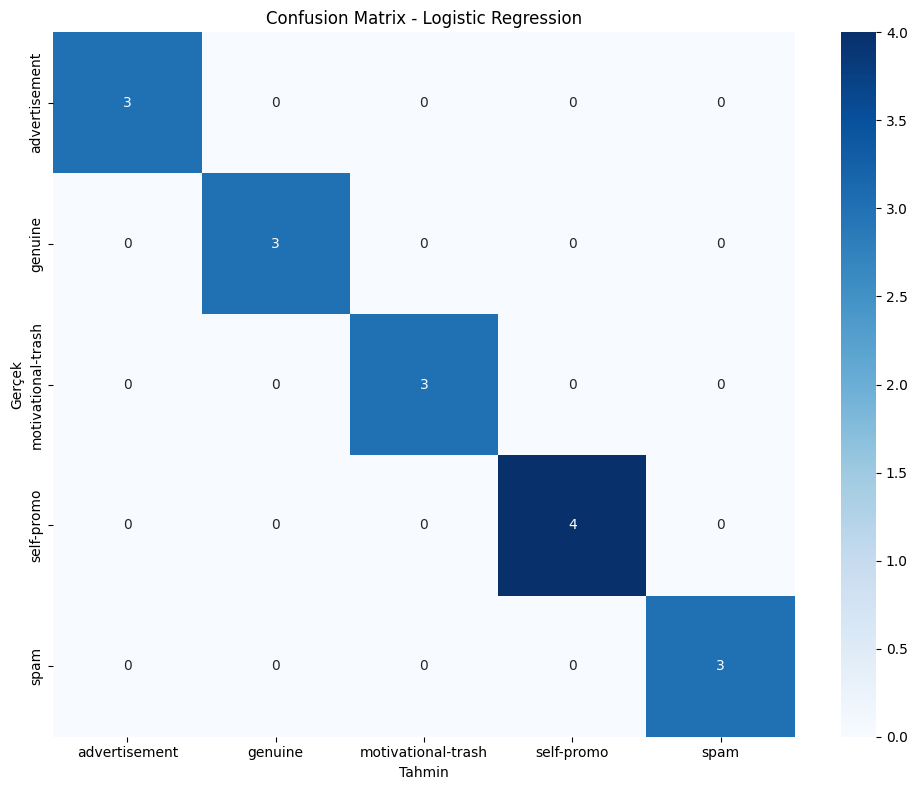

📊 Confusion matrix kaydedildi


In [9]:
# Confusion matrix
y_pred = results[best_model_name]['predictions']
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=best_model.classes_,
    yticklabels=best_model.classes_
)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.tight_layout()
plt.savefig(models_dir / 'confusion_matrix.png', dpi=150)
plt.show()

print("📊 Confusion matrix kaydedildi")


## 9. Model Test ve Örnek Tahminler


In [10]:
# Yeni metinlerle test
test_texts = [
    "I just published a new article about machine learning trends. Check it out!",
    "🔥🔥🔥 LIMITED TIME OFFER 🔥🔥🔥 90% DISCOUNT!!!",
    "Believe in yourself! You are amazing! 💪✨🌟",
    "After analyzing the data, I found some interesting patterns..."
]

# Embedding'leri çıkar
test_embeddings = embedding_model.encode(test_texts)

# Tahmin yap
predictions = best_model.predict(test_embeddings)
probabilities = best_model.predict_proba(test_embeddings)

print("\n🧪 Test Sonuçları:")
print("=" * 80)

for text, pred, prob in zip(test_texts, predictions, probabilities):
    max_prob = prob.max()
    print(f"\n📝 Metin: {text[:60]}...")
    print(f"🏷️  Tahmin: {pred}")
    print(f"📊 Güven: {max_prob:.2%}")
    print(f"   Tüm olasılıklar: {dict(zip(best_model.classes_, prob))}")



🧪 Test Sonuçları:

📝 Metin: I just published a new article about machine learning trends...
🏷️  Tahmin: genuine
📊 Güven: 45.40%
   Tüm olasılıklar: {np.str_('advertisement'): np.float64(0.116278710701811), np.str_('genuine'): np.float64(0.4540286671839482), np.str_('motivational-trash'): np.float64(0.09078462816807664), np.str_('self-promo'): np.float64(0.24972376210349748), np.str_('spam'): np.float64(0.08918423184266663)}

📝 Metin: 🔥🔥🔥 LIMITED TIME OFFER 🔥🔥🔥 90% DISCOUNT!!!...
🏷️  Tahmin: advertisement
📊 Güven: 47.57%
   Tüm olasılıklar: {np.str_('advertisement'): np.float64(0.47570230457879586), np.str_('genuine'): np.float64(0.054079591186012875), np.str_('motivational-trash'): np.float64(0.1546577665156519), np.str_('self-promo'): np.float64(0.09487262757864633), np.str_('spam'): np.float64(0.22068771014089303)}

📝 Metin: Believe in yourself! You are amazing! 💪✨🌟...
🏷️  Tahmin: motivational-trash
📊 Güven: 60.16%
   Tüm olasılıklar: {np.str_('advertisement'): np.float64(0.07265673

/Users/kara/Code/linkedinfeedcleaner/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kara/Code/linkedinfeedcleaner/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kara/Code/linkedinfeedcleaner/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/kara/Code/linkedinfeedcleaner/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kara/Code/linkedinfeedcleaner/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kara/Code/linkedinfeedcleaner/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


## 11. Modeli Pickle Formatında Kaydetme


In [11]:
# Modeli pickle formatında kaydet
import pickle
from pathlib import Path

# Models dizinini oluştur
models_dir = Path('../extension/models')
models_dir.mkdir(parents=True, exist_ok=True)

# En iyi modeli pickle formatında kaydet
model_path = models_dir / 'classifier_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

print(f"✅ Model pickle formatında kaydedildi: {model_path}")
print(f"   - Model tipi: {type(best_model).__name__}")
print(f"   - Dosya boyutu: {model_path.stat().st_size / 1024:.2f} KB")

# Metadata'yı da güncelle
metadata = {
    'model_name': best_model_name,
    'embedding_model': MODEL_NAME,
    'embedding_dim': embeddings.shape[1],
    'accuracy': float(results[best_model_name]['accuracy']),
    'classes': list(best_model.classes_)
}

metadata_path = models_dir / 'model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✅ Metadata kaydedildi: {metadata_path}")
print("\n🎉 Model pickle formatında kaydedildi!")
print("💡 Sonraki adım: ONNX formatına dönüştürmek için export_model_onnx.py scriptini kullanın.")


✅ Model pickle formatında kaydedildi: ../extension/models/classifier_model.pkl
   - Model tipi: LogisticRegression
   - Dosya boyutu: 16.07 KB
✅ Metadata kaydedildi: ../extension/models/model_metadata.json

🎉 Model pickle formatında kaydedildi!
💡 Sonraki adım: ONNX formatına dönüştürmek için export_model_onnx.py scriptini kullanın.


## 10. Sonraki Adımlar

1. ✅ Embedding modeli seçildi: `all-MiniLM-L6-v2`
2. ⏳ Gerçek veri setini topla ve etiketle
3. ⏳ Modeli eğit ve optimize et
4. ⏳ Modeli ONNX formatına dönüştür (tarayıcı için)
5. ⏳ Chrome Extension'a entegre et

### ONNX Dönüştürme (Sonraki notebook'ta)

Embedding modelini ONNX formatına dönüştürmek için bir sonraki notebook'u kullanacağız.
